<a href="https://colab.research.google.com/github/Safayat777/my_new/blob/main/snn_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install snntorch torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 5.3 MB/s eta 0:00:00


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

import snntorch as snn
from snntorch import spikegen
from snntorch import functional as SF

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


In [5]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [6]:
train_data = ImageFolder('/content/drive/MyDrive/DataSet/ArsenicSkinImageBD', transform=transform)
test_data  = ImageFolder('/content/drive/MyDrive/DataSet/Original', transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=32, shuffle=False)

classes = train_data.classes
print("Classes:", classes)


Classes: ['infected', 'not_infected']


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_steps = 50     # ↑ time steps = ↑ accuracy
beta = 0.9
epochs = 25
lr = 0.0005


In [8]:
class ImprovedSNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2)
        self.lif1 = snn.Leaky(beta=beta)

        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2)
        self.lif2 = snn.Leaky(beta=beta)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2)
        self.lif3 = snn.Leaky(beta=beta)

        self.fc1 = nn.Linear(64 * 4 * 4, 2)
        self.lif4 = snn.Leaky(beta=beta)

    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem4 = self.lif4.init_leaky()

        spk_out = []

        for t in range(num_steps):
            cur1 = self.pool1(self.conv1(x[t]))
            spk1, mem1 = self.lif1(cur1, mem1)

            cur2 = self.pool2(self.conv2(spk1))
            spk2, mem2 = self.lif2(cur2, mem2)

            cur3 = self.pool3(self.conv3(spk2))
            spk3, mem3 = self.lif3(cur3, mem3)

            cur4 = self.fc1(spk3.view(spk3.size(0), -1))
            spk4, mem4 = self.lif4(cur4, mem4)

            spk_out.append(spk4)

        return torch.stack(spk_out)


In [9]:
model = ImprovedSNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = SF.ce_rate_loss()


In [10]:
train_loss, train_acc = [], []

for epoch in range(epochs):
    model.train()
    correct, total, loss_sum = 0, 0, 0

    for data, targets in train_loader:
        data, targets = data.to(device), targets.to(device)

        # Spike encoding
        data = spikegen.rate(data, num_steps=num_steps)

        optimizer.zero_grad()
        spk_out = model(data)

        loss = loss_fn(spk_out, targets)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()

        pred = spk_out.sum(dim=0).argmax(dim=1)
        correct += (pred == targets).sum().item()
        total += targets.size(0)

    acc = 100 * correct / total
    avg_loss = loss_sum / len(train_loader)

    train_acc.append(acc)
    train_loss.append(avg_loss)

    print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Accuracy: {acc:.2f}%")


Epoch 1/25 | Loss: 0.6961 | Accuracy: 52.95%
Epoch 2/25 | Loss: 0.6787 | Accuracy: 59.85%
Epoch 3/25 | Loss: 0.6519 | Accuracy: 62.30%
Epoch 4/25 | Loss: 0.6419 | Accuracy: 62.66%
Epoch 5/25 | Loss: 0.6332 | Accuracy: 63.52%
Epoch 6/25 | Loss: 0.6283 | Accuracy: 64.07%
Epoch 7/25 | Loss: 0.6270 | Accuracy: 63.65%
Epoch 8/25 | Loss: 0.6246 | Accuracy: 64.14%
Epoch 9/25 | Loss: 0.6210 | Accuracy: 64.27%
Epoch 10/25 | Loss: 0.6168 | Accuracy: 64.48%
Epoch 11/25 | Loss: 0.6143 | Accuracy: 65.18%
Epoch 12/25 | Loss: 0.6110 | Accuracy: 65.80%
Epoch 13/25 | Loss: 0.6100 | Accuracy: 65.61%
Epoch 14/25 | Loss: 0.6058 | Accuracy: 66.32%
Epoch 15/25 | Loss: 0.6047 | Accuracy: 66.15%
Epoch 16/25 | Loss: 0.6032 | Accuracy: 66.39%
Epoch 17/25 | Loss: 0.6000 | Accuracy: 67.14%
Epoch 18/25 | Loss: 0.5976 | Accuracy: 67.51%
Epoch 19/25 | Loss: 0.5948 | Accuracy: 68.09%
Epoch 20/25 | Loss: 0.5920 | Accuracy: 68.54%
Epoch 21/25 | Loss: 0.5913 | Accuracy: 69.01%
Epoch 22/25 | Loss: 0.5898 | Accuracy: 69.1

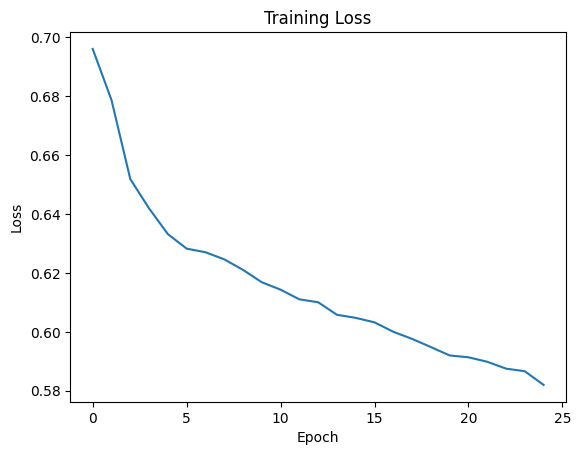

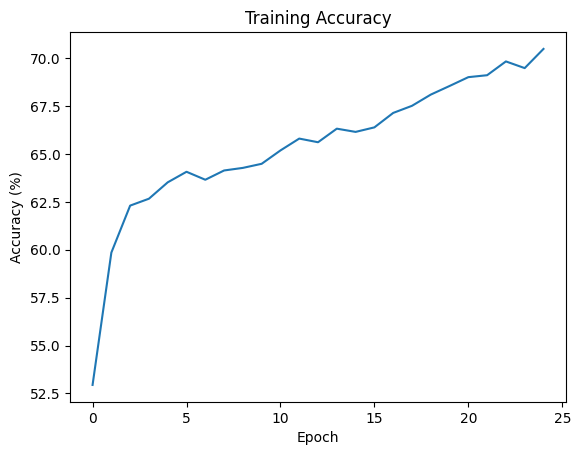

In [11]:
plt.figure()
plt.plot(train_loss)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.figure()
plt.plot(train_acc)
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.show()


In [12]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for data, targets in test_loader:
        data, targets = data.to(device), targets.to(device)
        data = spikegen.rate(data, num_steps=num_steps)

        spk_out = model(data)
        pred = spk_out.sum(dim=0).argmax(dim=1)

        correct += (pred == targets).sum().item()
        total += targets.size(0)

test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")


Test Accuracy: 75.99%


In [16]:
from google.colab import files
uploaded = files.upload()


Saving infected.png to infected.png


In [17]:
def predict_image(path):
    img = Image.open(path).convert('L')
    img = transform(img).unsqueeze(0).to(device)

    img = spikegen.rate(img, num_steps=num_steps)

    with torch.no_grad():
        spk_out = model(img)
        pred = spk_out.sum(dim=0).argmax(dim=1)

    return classes[pred.item()]


In [18]:
for file in uploaded.keys():
    print("Prediction:", predict_image(file))


Prediction: infected
